In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0,'../../')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import path
from tabulate import tabulate

%matplotlib inline

In [4]:
def get_score(model):
    scores = pd.read_table('../../models/%s/scores.tsv' % model)
    mean_score = scores.AP.mean()
    
    return mean_score

In [5]:
def plot_scores(xrange, scores, xlabel):
    plt.xlabel(xlabel)
    plt.ylabel('MAP')
    plt.xticks(xrange)
    plt.plot(xrange, scores, 'o--')

## Tunning

### Word vectors

In [6]:
args = 'word_vectors/%sfl=100_lens=3-4-5_act=relu_pool_s=1_kmax=None_wv_d=0.0_pool_d=0.5_conv_bn=0_pool_bn=0'

models = [
    ('naključni', args % ''),
    ('zvezna vreča', args % 'cbow_' ),
    ('Skip-Gram', args % 'skipgram_'),
]

word_vectors, models = zip(*models)
scores = [get_score(m) for m in models]
headers = ['besedni vektorji', 'MAP']
rows = zip(word_vectors, scores)

print(tabulate(rows, headers=headers, tablefmt='pipe', floatfmt=".4f"))

| besedni vektorji   |    MAP |
|:-------------------|-------:|
| naključni          | 0.2661 |
| zvezna vreča       | 0.1157 |
| Skip-Gram          | 0.2660 |


### Single filter length

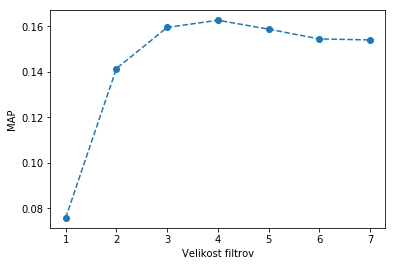

In [7]:
def get_single(fl):
    return 'single_region/fl=100_lens=%d_act=relu_pool_s=1_kmax=None_wv_d=0.0_pool_d=0.5_conv_bn=0_pool_bn=0' % fl

filter_lengths = list(range(1,8))
models = [get_single(fl) for fl in filter_lengths]
scores = [get_score(m) for m in models]
plot_scores(filter_lengths, scores, 'Velikost filtrov')

### Multiple filter lengths

In [8]:
args = 'fl=100_lens=%s_act=relu_pool_s=1_kmax=None_wv_d=0.0_pool_d=0.5_conv_bn=0_pool_bn=0'

models = [
    ('4', 'single_region/' + args % '4'),
    ('2, 3, 4', 'multiple_regions/' + args % '2-3-4'),
    ('3, 4, 5', 'word_vectors/' + args % '3-4-5'),
    ('4, 5, 6', 'multiple_regions/' + args % '4-5-6'),
    ('4, 4, 4', 'multiple_regions/' + args % '4-4-4'),
    ('3, 4, 5, 6', 'multiple_regions/' + args % '3-4-5-6'),
    ('4, 4, 4, 4', 'multiple_regions/' + args % '4-4-4-4'),
]

conf, models = zip(*models)
scores = [get_score(m) for m in models]
headers = ['velikost filtrov', 'MAP']
rows = zip(conf, scores)

print(tabulate(rows, headers=headers, tablefmt='pipe', floatfmt=".4f"))

| velikost filtrov   |    MAP |
|:-------------------|-------:|
| 4                  | 0.1627 |
| 2, 3, 4            | 0.2639 |
| 3, 4, 5            | 0.2661 |
| 4, 5, 6            | 0.2591 |
| 4, 4, 4            | 0.2681 |
| 3, 4, 5, 6         | 0.2872 |
| 4, 4, 4, 4         | 0.2897 |


### Activations

In [9]:
args = 'fl=100_lens=4_act=%s_pool_s=1_kmax=None_wv_d=0.0_pool_d=0.5_conv_bn=0_pool_bn=0'

models = [
    ('ReLU', 'single_region/' + args % 'relu'),
    ('sigmoid', 'activations/' + args % 'sigmoid'),
    ('softplus', 'activations/' + args % 'softplus'),
    ('tanh', 'activations/' + args % 'tanh'),
    ('brez', 'activations/' + args % 'None'),
]

activations, models = zip(*models)
scores = [get_score(m) for m in models]
headers = ['aktivacijska funkcija', 'MAP']
rows = zip(activations, scores)

print(tabulate(rows, headers=headers, tablefmt='pipe', floatfmt=".4f"))

| aktivacijska funkcija   |    MAP |
|:------------------------|-------:|
| ReLU                    | 0.1627 |
| sigmoid                 | 0.1582 |
| softplus                | 0.1496 |
| tanh                    | 0.2159 |
| brez                    | 0.2154 |


### Dropout

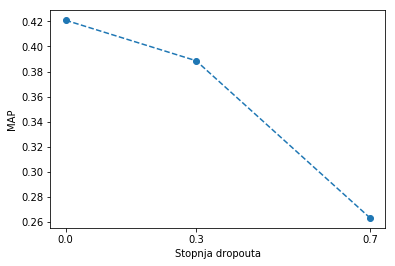

In [10]:
def get(p):
    return 'dropout/fl=300_lens=4_act=tanh_pool_s=1_kmax=None_wv_d=0.0_pool_d=%.1f_conv_bn=0_pool_bn=0' % p


rates = [.0, .3, .7]
models = [get(p) for p in rates]
scores = [get_score(m) for m in models]
plot_scores(rates, scores, 'Stopnja dropouta')

### Number of filters

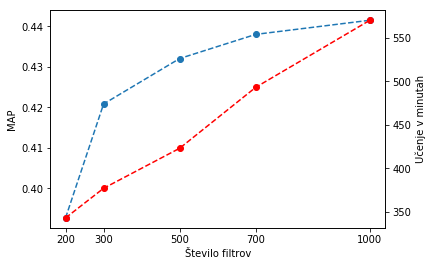

In [11]:
def get(nb):
    return 'fl=%d_lens=4_act=tanh_pool_s=1_kmax=None_wv_d=0.0_pool_d=0.0_conv_bn=0_pool_bn=0' % nb

models = [
    (200, 5*60 + 43, 'nb_filters/' + get(200)),
    (300, 6*60 + 17, 'dropout/' + get(300)),
    (500, 7*60 + 3, 'nb_filters/' + get(500)),
    (700, 8*60 + 13, 'nb_filters/' + get(700)),
    (1000, 9*60 + 30, 'nb_filters/' + get(1000)),
]

nb_filters, times, models = zip(*models)
scores = [get_score(m) for m in models]
plot_scores(nb_filters, scores, 'Število filtrov')
plt.twinx()
plt.plot(nb_filters, times, 'ro--')
plt.ylabel('Učenje v minutah');

### Regularization

In [12]:
def get(b):
    return 'nb_filters/fl=1000_lens=4_act=tanh_pool_s=1_kmax=None_wv_d=0.0_pool_d=0.0_conv_bn=%d_pool_bn=0' % b

models = [
    ('ne', get(0)),
    ('da', get(1)),
]

conf, models = zip(*models)
scores = [get_score(m) for m in models]
headers = ['normalizacija', 'MAP']
rows = zip(conf, scores)

print(tabulate(rows, headers=headers, tablefmt='pipe', floatfmt=".4f"))

| normalizacija   |    MAP |
|:----------------|-------:|
| ne              | 0.4415 |
| da              | 0.4713 |
